# Bernoulli HMM Example Notebook

Modified from https://github.com/lindermanlab/ssm-jax-refactor/blob/main/notebooks/bernoulli-hmm-example.ipynb

Changes: It uses pyprobml's dynamax library, and finds the permutation between inferrred and true latent state labels in a different way.


In [1]:
try:
    import dynamax
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/dynamax.git
    import dynamax

In [2]:
try:
    from probml_utils import savefig, latexify, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify, is_latexify_enabled

#### Imports and Plotting Functions 

In [3]:
from functools import partial
import jax.random as jr
import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pprint import pprint
import seaborn as sns
import tensorflow_probability.substrates.jax.distributions as tfd

from dynamax.hmm.models import BernoulliHMM

In [4]:
def gradient_cmap(colors, nsteps=256, bounds=None):
    """Return a colormap that interpolates between a set of colors.
    Ported from HIPS-LIB plotting functions [https://github.com/HIPS/hips-lib]
    Reference:
    https://github.com/lindermanlab/ssm/blob/646e1889ec9a7efb37d4153f7034c258745c83a5/ssm/plots.py#L20
    """
    ncolors = len(colors)
    # assert colors.shape[1] == 3
    if bounds is None:
        bounds = jnp.linspace(0, 1, ncolors)

    reds = []
    greens = []
    blues = []
    alphas = []
    for b, c in zip(bounds, colors):
        reds.append((b, c[0], c[0]))
        greens.append((b, c[1], c[1]))
        blues.append((b, c[2], c[2]))
        alphas.append((b, c[3], c[3]) if len(c) == 4 else (b, 1.0, 1.0))

    cdict = {"red": tuple(reds), "green": tuple(greens), "blue": tuple(blues), "alpha": tuple(alphas)}

    cmap = LinearSegmentedColormap("grad_colormap", cdict, nsteps)
    return cmap

In [5]:
def find_permutation(z1, z2):
    K1 = z1.max() + 1
    K2 = z2.max() + 1

    perm = []
    for k1 in range(K1):
        indices = jnp.where(z1 == k1)[0]
        counts = jnp.bincount(z2[indices])
        perm.append(jnp.argmax(counts))

    return jnp.array(perm)

In [6]:
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue", "red", "amber", "faded green", "dusty purple", "orange"]
colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


def plot_transition_matrix(transition_matrix):
    plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
    plt.xlabel("next state")
    plt.ylabel("current state")
    plt.colorbar()
    plt.show()


def compare_transition_matrix(true_matrix, test_matrix):
    # latexify(width_scale_factor=1, fig_height=1.5)
    figsize = (10, 5)
    if is_latexify_enabled():
        figsize = None
    latexify(width_scale_factor=1, fig_height=1.5)
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    out = axs[0].imshow(true_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[1].imshow(test_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[0].set_title("True Transition Matrix")
    axs[1].set_title("Test Transition Matrix")
    cax = fig.add_axes(
        [
            axs[1].get_position().x1 + 0.07,
            axs[1].get_position().y0,
            0.02,
            axs[1].get_position().y1 - axs[1].get_position().y0,
        ]
    )
    plt.colorbar(out, cax=cax)
    plt.show()


def plot_posterior_states(Ez, states, perm):
    # latexify(width_scale_factor=1, fig_height=1.5)
    figsize = (25, 5)
    if is_latexify_enabled():
        figsize = None
    plt.figure(figsize=figsize)
    plt.imshow(Ez.T[perm], aspect="auto", interpolation="none", cmap="Greys")
    plt.plot(states, label="True State", linewidth=1)
    plt.plot(Ez.T[perm].argmax(axis=0), "--", label="Predicted State", linewidth=1)
    plt.xlabel("time")
    plt.ylabel("latent state")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title("Predicted vs. Ground Truth Latent State")

# Bernoulli HMM

### Let's create a true model

In [7]:
num_states = 5
emission_dim = 10
true_hmm = BernoulliHMM(num_states, emission_dim, 
                        emission_prior_concentration0=1.0, 
                        emission_prior_concentration1=1.0)

In [8]:
initial_probs = jnp.ones((num_states,)) / (num_states * 1.0)
transition_matrix = 0.90 * jnp.eye(num_states) + 0.10 * jnp.ones((num_states, num_states)) / num_states
true_params, _ = true_hmm.initialize(key=jr.PRNGKey(0), initial_probs=initial_probs, transition_matrix=transition_matrix)
pprint(true_params)

{'emissions': {'probs': DeviceArray([[0.5101075 , 0.37463653, 0.15845723, 0.92877907, 0.915876  ,
              0.2781816 , 0.07606837, 0.67227226, 0.02824288, 0.8792381 ],
             [0.60166305, 0.17131579, 0.8953847 , 0.16232777, 0.21001732,
              0.3545916 , 0.37099373, 0.65532225, 0.5685262 , 0.5294375 ],
             [0.86292917, 0.07698138, 0.21009283, 0.48858947, 0.91662025,
              0.9897732 , 0.7091185 , 0.19263755, 0.57043606, 0.5730329 ],
             [0.977979  , 0.7871507 , 0.49274066, 0.9426948 , 0.4235999 ,
              0.36467838, 0.07442135, 0.20010759, 0.11953039, 0.34888312],
             [0.59595954, 0.65374476, 0.6496834 , 0.7097438 , 0.03907026,
              0.29472747, 0.20753238, 0.11125415, 0.6862083 , 0.60004115]],            dtype=float32)},
 'initial': {'probs': DeviceArray([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32)},
 'transitions': {'transition_matrix': DeviceArray([[0.91999996, 0.02      , 0.02      , 0.02      , 0.02      ],
           

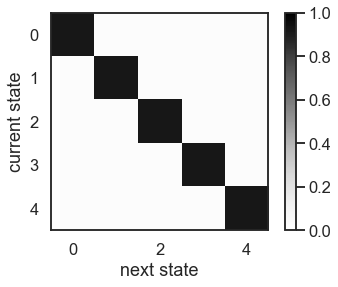

In [9]:
plot_transition_matrix(true_params["transitions"]["transition_matrix"])

In [10]:
print("Emission probabilities (num states x num emission_dims (aka channels)):")
print(true_params["emissions"]["probs"])

Emission probabilities (num states x num emission_dims (aka channels)):
[[0.5101075  0.37463653 0.15845723 0.92877907 0.915876   0.2781816
  0.07606837 0.67227226 0.02824288 0.8792381 ]
 [0.60166305 0.17131579 0.8953847  0.16232777 0.21001732 0.3545916
  0.37099373 0.65532225 0.5685262  0.5294375 ]
 [0.86292917 0.07698138 0.21009283 0.48858947 0.91662025 0.9897732
  0.7091185  0.19263755 0.57043606 0.5730329 ]
 [0.977979   0.7871507  0.49274066 0.9426948  0.4235999  0.36467838
  0.07442135 0.20010759 0.11953039 0.34888312]
 [0.59595954 0.65374476 0.6496834  0.7097438  0.03907026 0.29472747
  0.20753238 0.11125415 0.6862083  0.60004115]]


### From the true model, we can sample synthetic data

In [11]:
rng = jr.PRNGKey(0)
num_timesteps = 500

true_states, emissions = true_hmm.sample(true_params, rng, num_timesteps)

### Let's view the synthetic data

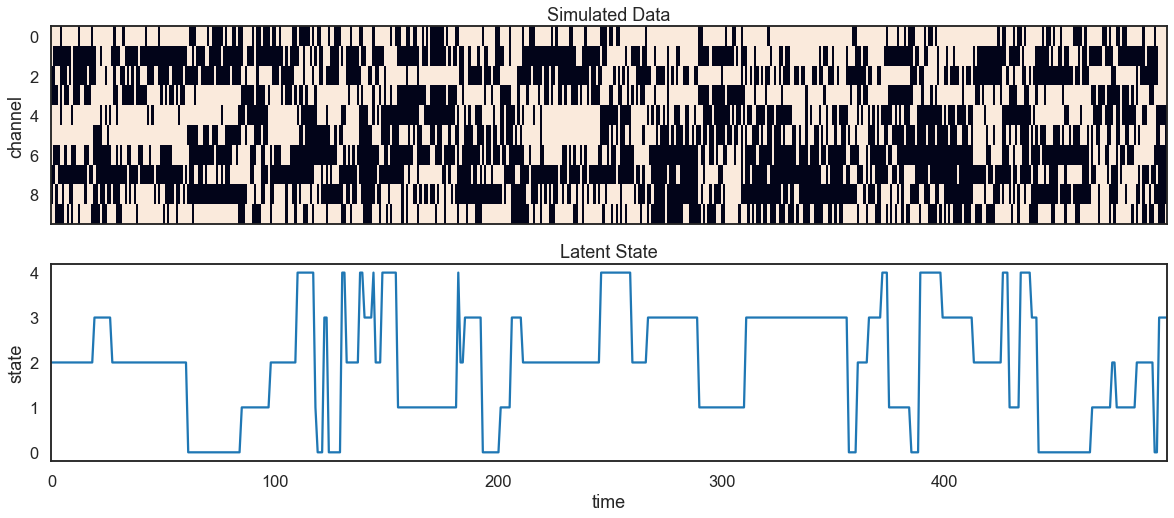

In [12]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
axs[0].imshow(emissions.T, aspect="auto", interpolation="none")
axs[0].set_ylabel("channel")
axs[0].set_title("Simulated Data")
axs[1].plot(true_states)
axs[1].set_title("Latent State")
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")
plt.show()

/Users/scott/miniconda3/envs/dynamax/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")
/Users/scott/miniconda3/envs/dynamax/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


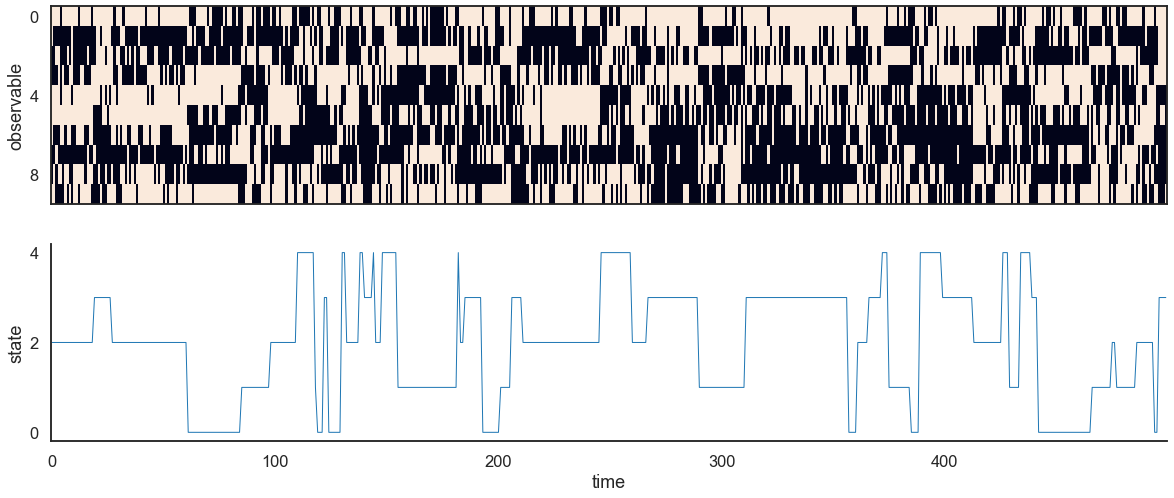

In [13]:
latexify(width_scale_factor=1, fig_height=2)
figsize = (20, 8)
if is_latexify_enabled():
    figsize = None
fig, axs = plt.subplots(2, 1, sharex=True, figsize=figsize)
axs[0].imshow(emissions.T, aspect="auto", interpolation="none")
axs[0].set_ylabel("observable")
axs[0].set_yticks([0, 4, 8])
axs[1].plot(true_states, linewidth=1)
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")
axs[1].set_yticks([0, 2, 4])
axs[1].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False)
if is_latexify_enabled():
    plt.subplots_adjust(hspace=4)
savefig("bernoulli-hmm-data")
plt.show()

## Fit HMM using exact EM update

In [14]:
test_hmm = BernoulliHMM(num_states, emission_dim)
test_params, test_props = test_hmm.initialize(key=jr.PRNGKey(1))

In [15]:
num_iters = 20
test_params, lps = test_hmm.fit_em(test_params, test_props, emissions, num_iters=num_iters)

  0%|          | 0/20 [00:00<?, ?it/s]

Text(0, 0.5, 'log likelihood')

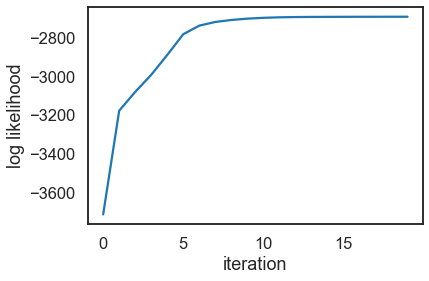

In [16]:
# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")

In [17]:
test_params["transitions"]["transition_matrix"]

DeviceArray([[0.1783361 , 0.05315915, 0.00342374, 0.64745915, 0.11762184],
             [0.0454781 , 0.9038586 , 0.04035348, 0.00250742, 0.0078024 ],
             [0.02209921, 0.03577564, 0.9135482 , 0.01425192, 0.01432501],
             [0.26099607, 0.04549916, 0.04304772, 0.64875513, 0.00170196],
             [0.05608905, 0.01567338, 0.04640983, 0.00190126, 0.87992644]],            dtype=float32)

/Users/scott/miniconda3/envs/dynamax/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


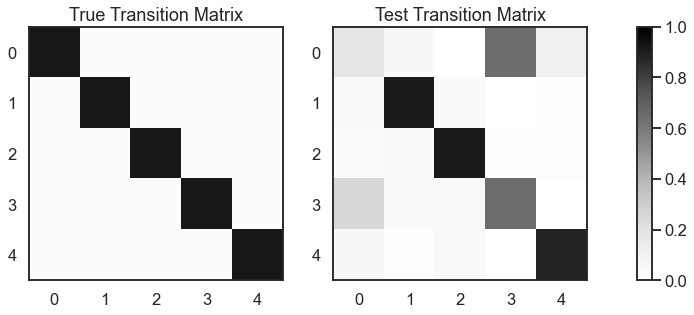

In [18]:
# Compare the transition matrices
compare_transition_matrix(true_params["transitions"]["transition_matrix"], test_params["transitions"]["transition_matrix"])

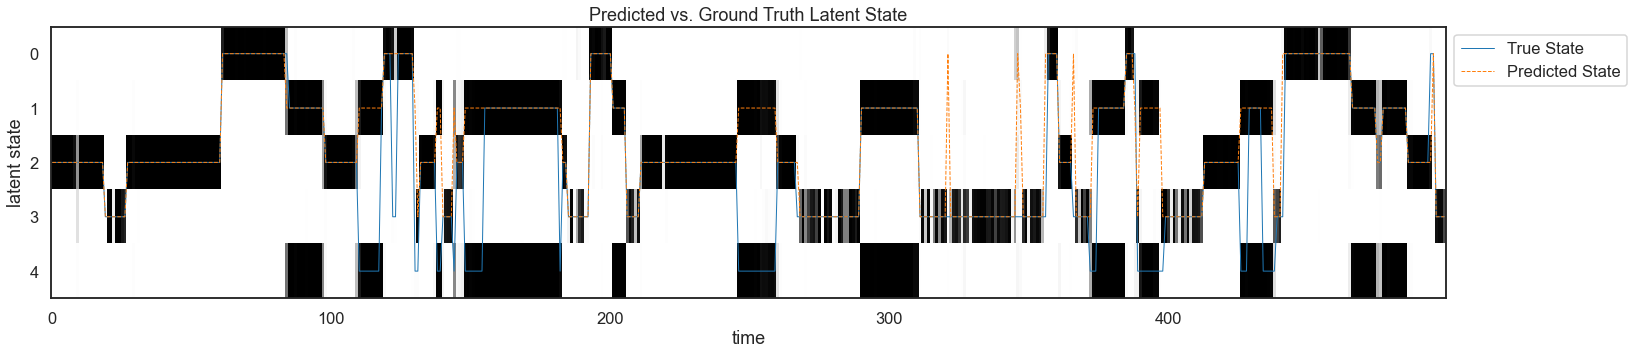

In [19]:
# Posterior distribution
posterior = test_hmm.smoother(test_params, emissions)
Ez = posterior.smoothed_probs
perm = find_permutation(true_states, jnp.argmax(Ez, axis=-1))
plot_posterior_states(Ez, true_states, perm)

# Fit Bernoulli Over Multiple Trials

In [20]:
rng = jr.PRNGKey(0)
num_trials = 5
keys = jr.split(rng, num_trials)
num_timesteps = 500

all_true_states, all_emissions = vmap(partial(true_hmm.sample, true_params, num_timesteps=num_timesteps))(keys)

In [21]:
# Now we have a batch dimension of size `num_trials`
print(all_true_states.shape)
print(all_emissions.shape)

(5, 500)
(5, 500, 10)


In [22]:
num_iters = 100
test_parms, test_props = test_hmm.initialize(key=jr.PRNGKey(2))
test_params, lps = test_hmm.fit_em(test_params, test_props, all_emissions, num_iters=100)

  0%|          | 0/100 [00:00<?, ?it/s]

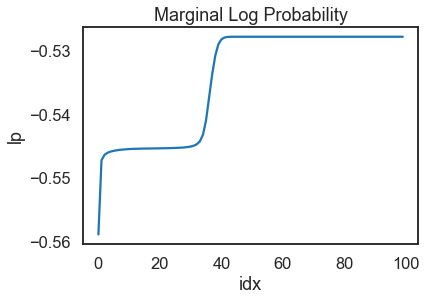

In [23]:
# plot marginal log probabilities
plt.title("Marginal Log Probability")
plt.ylabel("lp")
plt.xlabel("idx")
plt.plot(jnp.array(lps) / all_emissions.size)

/Users/scott/miniconda3/envs/dynamax/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


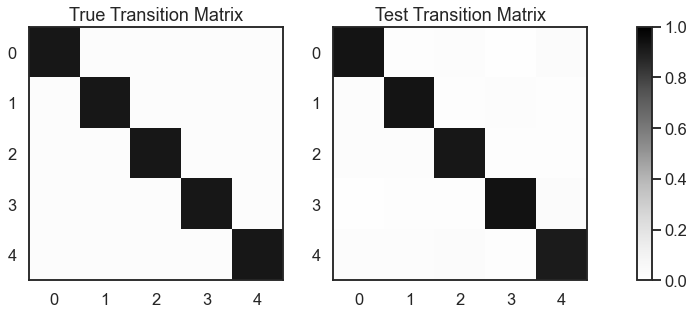

In [24]:
# Compare the transition matrices
compare_transition_matrix(true_params["transitions"]["transition_matrix"], test_params["transitions"]["transition_matrix"])

===== Trial: 0 =====
===== Trial: 1 =====
===== Trial: 2 =====


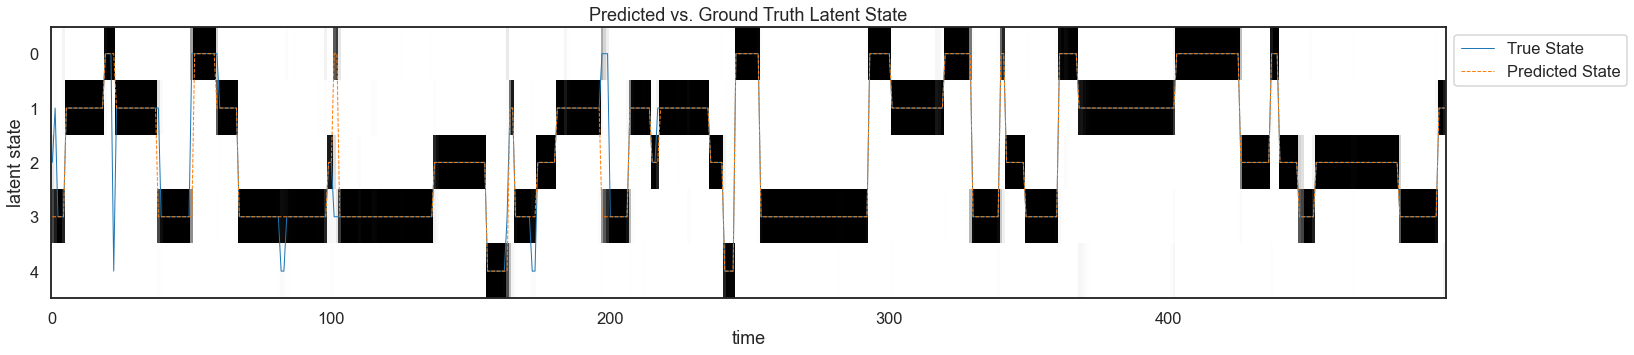

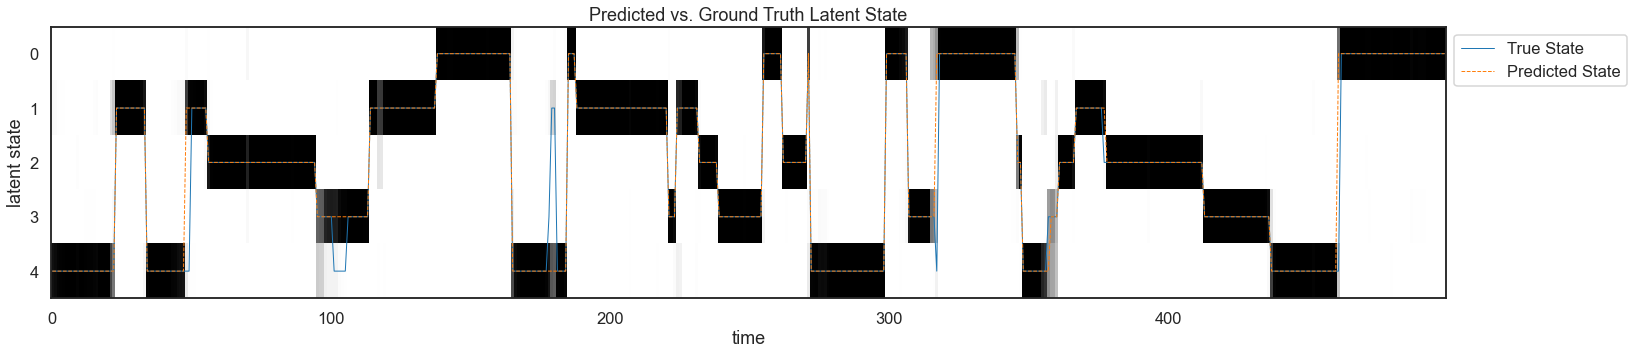

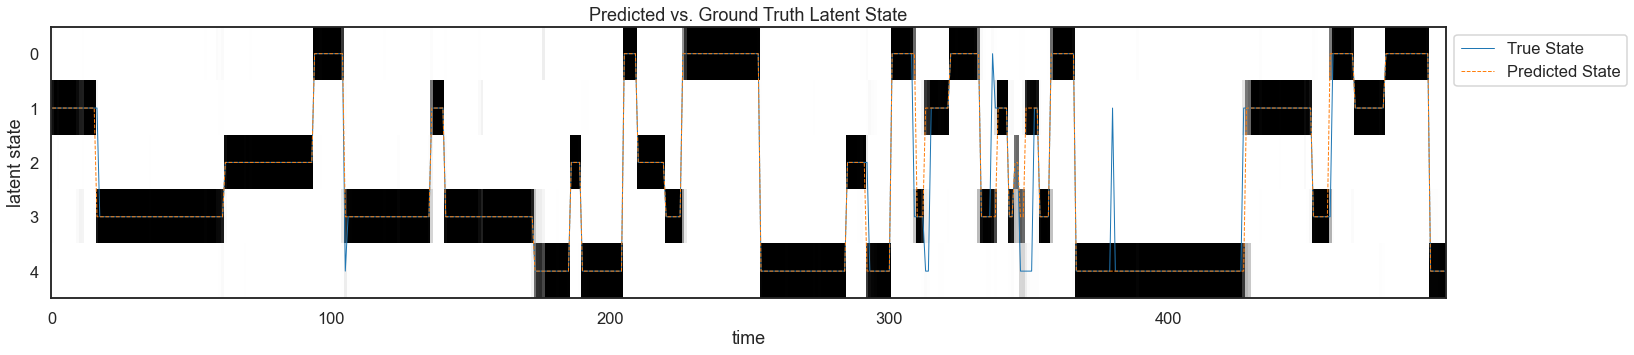

In [25]:
# For the first few trials, let's see how good our predicted states are
for trial_idx in range(3):
    print("=" * 5, f"Trial: {trial_idx}", "=" * 5)
    posterior = test_hmm.smoother(test_params, all_emissions[trial_idx])
    Ez = posterior.smoothed_probs
    states = all_true_states[trial_idx]
    perm = find_permutation(states, jnp.argmax(Ez, axis=-1))
    plot_posterior_states(Ez, states, perm)